In [1]:
import allutils.graph_generator
from allutils.general_PR import flowPR
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pickle
import uuid
import sys
from allutils.utils_experiments import *

In [2]:


#mode = sys.argv[1]
#mode = 'SFree'
mode = 'facebook'

do_plot = True
do_dump = False

n = 100 #number of nodes in the graph
iters = 100000 #number of temporal edges in the graph

alpha = 0.85
beta = 0.0
gamma = 1.0

if mode != 'random':
    weights = 'real'
else:
    weights = 'random'

In [27]:
G = allutils.graph_generator.weighted_DiGraph(n, seed = 1.0, mode = mode, weights = weights)
norm = sum([val for (node, val) in G.degree()])
sampling_edges = {e[:-1]: e[-1]['weight']/norm for e in G.edges(data=True)}
stream = [list(sampling_edges.keys())[i] for i in np.random.choice(range(len(sampling_edges)), size=iters,)]# p=sampling_edges.values()


344
DiGraph with 100 nodes and 3733 edges


In [30]:

# basic (degree personalization)
personalization = {k: v / norm for k, v in G.degree()}
p_prime_nodes = {i: personalization[i]/G.out_degree(i, weight='weight') for i in G.nodes()}
pr_basic = nx.pagerank(G, alpha=alpha, personalization=personalization, weight='weight')
RS4_basic, current_basic = {}, {}
RS4_basic, current_basic, tau_basic, spearman_basic, pearson_basic, error_basic, x = flowPR(p_prime_nodes, pr_basic, stream, RS4_basic, current_basic, iters = iters, beta = beta, gamma = gamma)


169291.52072393126


In [31]:

# no personalization
personalization = {k: 1.0 / G.number_of_nodes() for k in G.nodes()}
p_prime_nodes = {i: personalization[i]/G.out_degree(i, weight='weight') for i in G.nodes()}
pr_nopers = nx.pagerank(G, alpha=alpha, personalization=personalization, weight='weight')
RS4_nopers, current_nopers = {}, {}
RS4_nopers, current_nopers, tau_nopers, spearman_nopers, pearson_nopers, error_nopers, x = flowPR(p_prime_nodes, pr_nopers, stream,RS4_nopers, current_nopers, iters = iters, beta = beta, gamma = gamma)


153950.07569067375


In [32]:
# random personalization
personalization = {k: np.random.uniform(1e-5, 1.0) for k in G.nodes()}
personalization = {k: v/ sum(personalization.values()) for k,v in personalization.items()}
p_prime_nodes = {i: personalization[i]/G.out_degree(i, weight='weight') for i in G.nodes()}
pr_rand = nx.pagerank(G, alpha=alpha, personalization=personalization, weight='weight')
RS4_rand, current_rand = {}, {}
RS4_rand, current_rand, tau_rand, spearman_rand, pearson_rand, error_rand, x = flowPR(p_prime_nodes, pr_rand, stream, RS4_rand, current_rand, iters = iters, beta = beta, gamma = gamma)


153995.021909379


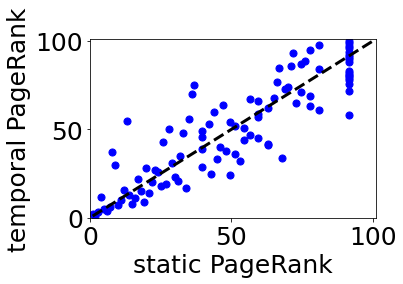

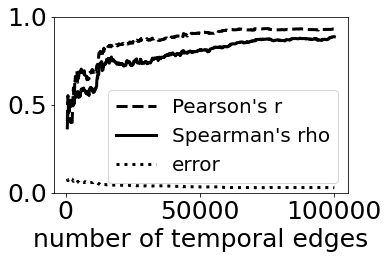

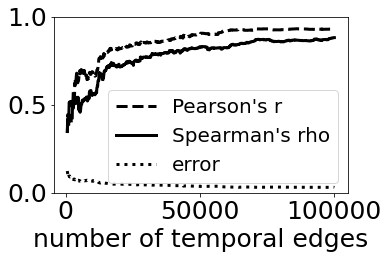

In [33]:


if do_dump:        
    unique_out = mode + '_personalization_' + str(uuid.uuid4())
    pickle.dump([pr_basic, RS4_basic, pearson_basic, spearman_basic, tau_basic, error_basic, x,
                    pr_nopers, RS4_nopers, pearson_nopers, spearman_nopers, tau_nopers, error_nopers,
                    pr_rand, RS4_rand, pearson_rand, spearman_rand, tau_rand, error_rand], open(unique_out+".p", "wb"))
if do_plot:

    ordered_pr_ref_basic, ordered_pr_out_basic = get_ordered_ranks(pr_basic, RS4_basic)
    ordered_pr_ref_nopers, ordered_pr_out_nopers = get_ordered_ranks(pr_nopers, RS4_nopers)
    ordered_pr_ref_rand, ordered_pr_out_rand = get_ordered_ranks(pr_rand, RS4_rand)

    plt.rcParams.update({'font.size': 20, 'lines.linewidth': 3})
    plt.rcParams['xtick.labelsize'] = 25
    plt.rcParams['ytick.labelsize'] = 25
    
    
    # scatter plot for rankings
    plt.figure('scatter_' + mode)
    plt.scatter(ordered_pr_ref_basic, ordered_pr_out_basic, s=50, c='b')
    plt.plot(range(1, 101), range(1, 101), 'k--')
    plt.xlabel('static PageRank', fontsize=25)
    plt.ylabel('temporal PageRank', fontsize=25)
    plt.ylim((0, 101))
    plt.xlim((0, 101))
    plt.tight_layout()
    plt.savefig(mode + '_scatter.pdf')

    
    
    plt.figure('convergence_basic_' + mode)        
    plt.plot(x, pearson_basic, 'k--')
    plt.plot(x, spearman_basic, 'k-')
    #plt.plot(x, tau_basic, 'k-.')
    plt.plot(x, error_basic, 'k:')
    plt.xlabel('number of temporal edges', fontsize=25)
    plt.ylim((0, 1))
    plt.legend(['Pearson\'s r', 'Spearman\'s rho', 'error'], loc=0)
    plt.tight_layout()
    plt.savefig(mode+'_convergence_basic.pdf')
    
    
    
    plt.figure('convergence_rand' + mode)
    plt.plot(x, pearson_rand, 'k--')
    plt.plot(x, spearman_rand, 'k-')
    #plt.plot(x, tau_basic, 'k-.')
    plt.plot(x, error_rand, 'k:')
    plt.xlabel('number of temporal edges', fontsize=25)
    plt.ylim((0, 1))
    plt.legend(['Pearson\'s r', 'Spearman\'s rho', 'error'], loc=0)
    plt.tight_layout()
    plt.savefig(mode+'_convergence_rand.pdf')
    #plt.show()
